In [1]:
!pip install p3_data

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [3]:
import p3_data
from p3_data import (glob_file_list , load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [45]:
src_files = []
src_files += ['../../data/results/json/*.json']# Pulsar
src_files += ['../../pulsar_data12t/data/results/json/*.json']
raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 33 files...


In [46]:
def clean_result(result):
    try:
        r = result.copy()
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
r = clean_result(raw_df.iloc[0])
pd.DataFrame(r)

,0
ansible,True
ansible_vars,"{'bookkeeperVersion': '4.9.2', 'prometheusVers..."
build,False
command_timed_out,False
driver,Pulsar
...,...
publishRateMBPerSecMean,1.00217
publishLatencyMsAvg,3.19104
publishLatencyMs99Pct,4.324
endToEndLatencyMsAvg,3.47024


In [47]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [48]:
clean_df.columns.values

array(['ansible', 'ansible_vars', 'build', 'command_timed_out', 'driver',
       'elapsed_sec', 'error', 'errors', 'exit_code', 'git_commit',
       'localWorker', 'max_test_attempts', 'noop', 'numWorkers',
       'omb_results', 'omb_workers', 'output', 'print_output',
       'record_utc', 'record_uuid', 'result_filename', 'run_as_test',
       'sequence_in_test_batch', 'size_of_test_batch', 'ssh_host',
       'ssh_identity_file', 'ssh_user', 'status_html', 'tarball',
       'terraform', 'terraform_show', 'test', 'test_attempt',
       'test_batch_uuid', 'test_desc', 'test_driver_log_filename',
       'test_driver_version', 'test_uuid', 'undeploy', 'utc_begin',
       'utc_end', 'loaded_filename', 'driverName', 'ackQuorum',
       'deduplicationEnabled', 'ensembleSize', 'writeQuorum',
       'consumerBacklogSizeGB', 'consumerPerSubscription',
       'keyDistributor', 'messageSize', 'name', 'partitionsPerTopic',
       'payloadFile', 'producerRate', 'producersPerTopic',
       'subscrip

In [49]:
info_cols = [
    'numWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
]

In [50]:
cols = [
    'messageSize',
    'numWorkloadWorkers',
    'producersPerTopic',
    'partitionsPerTopic',
    'testDurationMinutes',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'ackQuorum',
    'throttleEventsPerSec',
    #'deduplicationEnabled',
    'publishRateEventsPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMsAvg',
    'publishLatencyMs99Pct',
    'endToEndLatencyMsAvg',
    'endToEndLatencyMs99Pct',
    'utc_begin',
]

In [51]:
clean_df[cols].tail(2).T

test_uuid,b858593a-a397-4278-a2b8-3f7e185b055b,81534947-de56-4ba9-b998-d1443d706be9
messageSize,10000,10000
numWorkloadWorkers,4,4
producersPerTopic,4,4
partitionsPerTopic,1,1
testDurationMinutes,1,1
subscriptionsPerTopic,1,1
consumerPerSubscription,1,1
ackQuorum,2,2
throttleEventsPerSec,50000,-1
publishRateEventsPerSecMean,27042.6,27619.9


In [52]:
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [53]:
df = clean_df[cols]
df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
df.head()

,messageSize,numWorkloadWorkers,producersPerTopic,partitionsPerTopic,testDurationMinutes,subscriptionsPerTopic,consumerPerSubscription,ackQuorum,throttleEventsPerSec,publishRateEventsPerSecMean,publishRateMBPerSecMean,publishLatencyMsAvg,publishLatencyMs99Pct,endToEndLatencyMsAvg,endToEndLatencyMs99Pct,utc_begin
test_uuid,,,,,,,,,,,,,,,,
840ee73e-cca8-497d-b689-cf2587e32b30,100,4,4,16,1,1,16,2,-1.0,2.792709e+06,279.270914,17.443383,64.205,76150.230807,101427.199,2020-04-20T13:21:07.180409
367f1350-5578-4638-ab81-5d2b3fe93600,100,4,4,1,1,1,1,2,-1.0,1.531701e+06,153.170114,26.051498,61.975,43887.349404,57979.135,2020-04-20T18:26:23.874036
345fb9e9-beb9-43ba-88d1-2e390d26358c,100,4,4,16,1,1,16,2,30.0,3.005573e+01,0.003006,3.180589,4.320,3.453039,5.000,2020-04-20T12:55:00.479769
1fd13827-5de4-4033-9bd3-644b2e834adf,100,4,4,16,1,1,16,2,100.0,1.002515e+02,0.010025,3.006103,4.140,3.196420,5.000,2020-04-20T12:57:11.584703
5fe4c41b-ec9b-40db-ba68-79b56543864a,100,4,4,1,1,1,1,2,100.0,1.002379e+02,0.010024,2.910792,4.025,7.852693,13.000,2020-04-20T18:13:27.583347


In [62]:
messageSize = 100 # 10000
filt_df = filter_dataframe(
    clean_df,
    driverName='Pulsar',
    messageSize=messageSize, 
#     producerRate=5e4,
    numWorkloadWorkers=4, 
    producersPerTopic=4,
    partitionsPerTopic=1, # 16,
    deduplicationEnabled=True,
    testDurationMinutes=1,    
)
filt_df[cols].sort_values(['publishRateMBPerSecMean'], ascending=False).head(20)

,messageSize,numWorkloadWorkers,producersPerTopic,partitionsPerTopic,testDurationMinutes,subscriptionsPerTopic,consumerPerSubscription,ackQuorum,throttleEventsPerSec,publishRateEventsPerSecMean,publishRateMBPerSecMean,publishLatencyMsAvg,publishLatencyMs99Pct,endToEndLatencyMsAvg,endToEndLatencyMs99Pct,utc_begin
test_uuid,,,,,,,,,,,,,,,,
367f1350-5578-4638-ab81-5d2b3fe93600,100,4,4,1,1,1,1,2,-1.0,1.531701e+06,153.170114,26.051498,61.975,43887.349404,57979.135,2020-04-20T18:26:23.874036
c6d55c08-c2a6-4b06-8a40-93ce964b4837,100,4,4,1,1,1,1,2,1000000.0,1.002789e+06,100.278885,4.682230,12.209,13.453497,78.000,2020-04-20T18:24:14.511983
6078ade9-d8f9-48f2-b0a3-4d88c3aa70e6,100,4,4,1,1,1,1,2,100000.0,1.002188e+05,10.021882,2.501968,4.036,8.357012,14.000,2020-04-20T18:22:05.308091
ba860902-804f-4a23-9894-be7bdbbce30c,100,4,4,1,1,1,1,2,50000.0,5.010948e+04,5.010948,2.633258,4.013,8.521652,14.000,2020-04-20T18:19:55.933485
63a06002-795f-4c3d-8e8d-e98f65a92176,100,4,4,1,1,1,1,2,10000.0,1.002222e+04,1.002222,2.669703,3.996,8.375830,14.000,2020-04-20T18:17:46.727033
39917dd8-2220-49d9-b478-6055c9afd395,100,4,4,1,1,1,1,2,1000.0,1.003110e+03,0.100311,2.403386,3.978,7.569470,14.000,2020-04-20T18:15:37.060199
5fe4c41b-ec9b-40db-ba68-79b56543864a,100,4,4,1,1,1,1,2,100.0,1.002379e+02,0.010024,2.910792,4.025,7.852693,13.000,2020-04-20T18:13:27.583347


In [55]:
take_varying_columns(filt_df[cols]).sort_values(['endToEndLatencyMs99Pct'], ascending=True).head(20)

,throttleEventsPerSec,publishRateEventsPerSecMean,publishRateMBPerSecMean,publishLatencyMsAvg,publishLatencyMs99Pct,endToEndLatencyMsAvg,endToEndLatencyMs99Pct,utc_begin
test_uuid,,,,,,,,
bb2cd97c-2979-4290-887f-004e5049811b,30.0,30.081107,0.300811,3.270735,4.404,3.521282,5.000,2020-04-20T13:23:19.299212
066ed859-ef60-4aa9-ad80-b307432b6327,100.0,100.216930,1.002169,3.191037,4.324,3.470237,5.000,2020-04-20T13:25:29.830867
3999b6a2-00a2-4d87-a1cd-df469fd91de2,300.0,300.643179,3.006432,3.061038,4.224,3.357874,5.000,2020-04-20T13:27:40.332296
c2447c83-4dbc-4048-9912-04b5581eb564,1000.0,1002.185245,10.021852,2.818160,4.138,5.494086,13.000,2020-04-20T13:29:50.641665
6c4e07f2-54cd-4edf-a98e-12bd74a629bb,3000.0,3015.401263,30.154013,2.806120,4.195,7.337999,14.000,2020-04-20T13:32:00.709789
d34049cd-d7f4-4f9b-a98b-422bd8d9159c,10000.0,10024.443270,100.244433,3.353296,4.951,8.604888,15.000,2020-04-20T13:34:10.941501
a880ca24-f520-4189-875d-3f8b36591681,30000.0,30126.338359,301.263384,4.582670,36.621,10.238072,43.000,2020-04-20T13:36:21.125410
154038d6-3aa6-40a1-9e1a-0ea080858d27,-1.0,5703.708094,57.037081,4194.317377,24060.159,10231.180661,38052.095,2020-04-20T13:38:31.518577


In [56]:
plot_df = (filt_df
    .set_index(['publishRateMBPerSecMean'])
    .sort_index()
    [[
        'aggregatedPublishLatency50pct',
        'aggregatedPublishLatency95pct',
        'aggregatedPublishLatency99pct',
        'aggregatedEndToEndLatency50pct',
        'aggregatedEndToEndLatency95pct',
        'aggregatedEndToEndLatency99pct',
        'test_uuid',
    ]]
    .rename(columns=dict(
        aggregatedPublishLatency50pct='Publish Latency p50',
        aggregatedPublishLatency95pct='Publish Latency p95',
        aggregatedPublishLatency99pct='Publish Latency p99',
        aggregatedEndToEndLatency50pct='E2E Latency p50',
        aggregatedEndToEndLatency95pct='E2E Latency p95',
        aggregatedEndToEndLatency99pct='E2E Latency p99',
    ))
    )
plot_df.index.name = 'Publish Throughput (MB/s)'
plot_df

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Publish Throughput (MB/s),,,,,,,
0.300811,3.259,4.231,4.404,3.000,5.000,5.000,bb2cd97c-2979-4290-887f-004e5049811b
1.002169,3.161,4.141,4.324,3.000,5.000,5.000,066ed859-ef60-4aa9-ad80-b307432b6327
3.006432,3.042,4.060,4.224,3.000,4.000,5.000,3999b6a2-00a2-4d87-a1cd-df469fd91de2
10.021852,2.778,3.972,4.138,4.000,12.000,13.000,c2447c83-4dbc-4048-9912-04b5581eb564
30.154013,2.735,4.012,4.195,7.000,13.000,14.000,6c4e07f2-54cd-4edf-a98e-12bd74a629bb
57.037081,172.820,20401.919,24060.159,461.001,37489.151,38052.095,154038d6-3aa6-40a1-9e1a-0ea080858d27
100.244433,3.158,4.455,4.951,8.000,13.000,15.000,d34049cd-d7f4-4f9b-a98b-422bd8d9159c
301.263384,3.689,5.477,36.621,9.000,15.000,43.000,a880ca24-f520-4189-875d-3f8b36591681


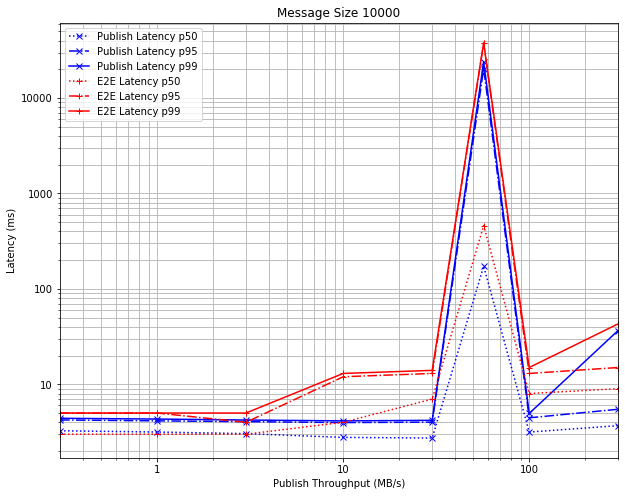

In [57]:
title = 'Message Size %d' % (messageSize)
ax = plot_df.plot(
    logx=True, 
    logy=True,
    figsize=(10,8), 
    grid=True, 
    title=title, 
    style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
ax.set_ylabel('Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax.xaxis.set_major_formatter(tick_formatter)
ax.yaxis.set_major_formatter(tick_formatter)
ax.grid('on', which='both', axis='both')

In [58]:
filt_df[info_cols].drop_duplicates().T

test_uuid,bb2cd97c-2979-4290-887f-004e5049811b
numWorkers,4
topics,1
partitionsPerTopic,16
producersPerTopic,4
subscriptionsPerTopic,1
consumerPerSubscription,16
testDurationMinutes,1
keyDistributor,NO_KEY
git_commit,e26cf7d [revert] change to testgen_pulsar_ssh.py


In [59]:
# plot_groups(
#     filt_df, 
#     x_col='publishRateEventsPerSecMean',
#     y_col='publishLatencyMs99Pct',
#     group_by_columns=['partitionsPerTopic', 'messageSize'],
#     semilogx=True,
# #     ylim=[0,100],
# );

# Analyze Latency Distribution

In [37]:
df = clean_df
df = df[df.test_uuid=='7260fa6a-aa29-4eaf-ad53-dc61bf072ddc']
t = df.iloc[0]
t

ansible                                                                 True
ansible_vars               {'bookkeeperVersion': '4.9.2', 'prometheusVers...
build                                                                  False
command_timed_out                                                      False
driver                                                                Pulsar
                                                 ...                        
publishRateMBPerSecMean                                                5.012
publishLatencyMsAvg                                                  2.62067
publishLatencyMs99Pct                                                  4.069
endToEndLatencyMsAvg                                                 8.10735
endToEndLatencyMs99Pct                                                    14
Name: 7260fa6a-aa29-4eaf-ad53-dc61bf072ddc, Length: 107, dtype: object

In [38]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

In [39]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

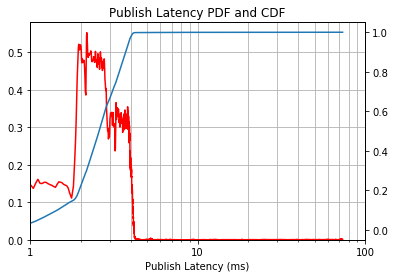

In [41]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [42]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

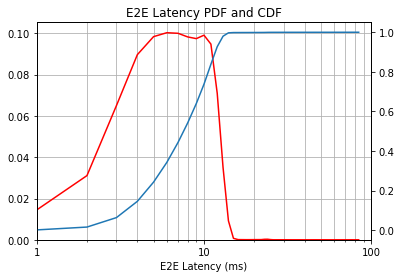

In [43]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

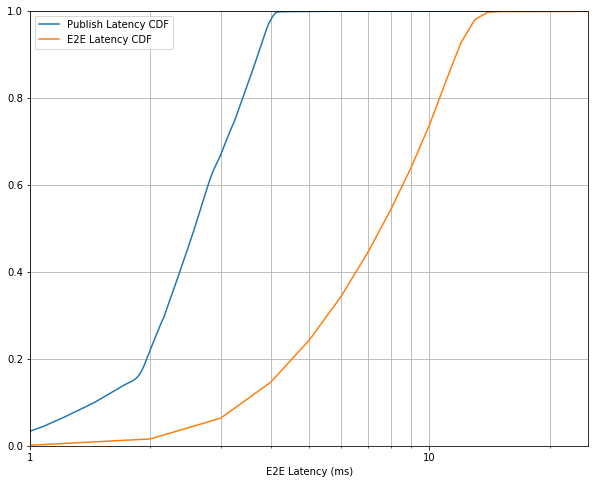

In [44]:
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()